# Navigating TTFs via FontTools#

by [Lynne Yun](https://www.lynneyun.com)

If you've ever tried to parse font files like TTFs, you'll know that it's no simple task. However, there is a powerful python module called FontTools that can help you! In this mini-tutorial, I'll go over how to use some functions of `fontTools`, and eventually illustrate what we can do with them via `drawBot`. This post was inspired by [Allison Parrish](https://www.decontextualize.com/)'s Notebook on [Manipulating Font Data](https://github.com/aparrish/material-of-language/blob/master/manipulating-font-data.ipynb), so check that out if you want more context!

This first cell demonstrates installing drawBot and fonttools if you don't have them already. Uncomment and install if necessary:

In [ ]:
#!pip install git+https://github.com/typemytype/drawbot
#!pip install fonttools

## fontTools ##
What is fontTools you say? You can check out the library here: [fontTools Python library](https://rsms.me/fonttools-docs/). For our first example, let's try to grab basic information, such as the GlyphID. I'm importing an open-source typeface here, called Noto Sans.

### Calling the GlyphID ###

In [1]:
from fontTools.ttLib import TTFont
font = TTFont("./NotoSans-Regular.ttf")
print('glyphID is: ' + str(font.getGlyphID('a')))

glyphID is: 68


Now, that's the `glyphID`, which is not the Unicode Codepoint. Glyph IDs are the order in which the glyphs have been arranged in a font file, and may not be the same across different fonts. 

### Calling the Unicode Codepoint ###
In case you want to grab the unicode codepoint represented as an integer, you can use `ord`.

In [2]:
print(ord('a'))

97


### Calling the Glyph Width ###
In font files, there are 'widths' of each glyph. They include the left and right sidebearings. Access the advances with the font object's `.width` attribute. You will have to call `getGlyphSet()` in order to do so.

In [3]:
glyph = font.getGlyphSet()['a']
print('width of glyph is ' + str(glyph.width))

width of glyph is 561


### Units Per Em Value ###

You can also get the `unitsPerEm` attribute of the font object from the `_c_m_a_p`:

In [4]:
from fontTools.ttLib.tables._c_m_a_p import CmapSubtable
units_per_em = font['head'].unitsPerEm
print('units per em is: ' + str(units_per_em))

units per em is: 1000


### Getting Glyph Outlines via RecordingPen ###
Let's try to do something a bit more interesting, perhaps — let's grab all the points from the glyph using a `RecordingPen`.

In [5]:
from fontTools.pens.recordingPen import RecordingPen
glyph = font.getGlyphSet()['a']
p = RecordingPen()
glyph.draw(p)
p.value

[('moveTo', ((288, 545),)),
 ('qCurveTo', ((386, 545), (480, 459), (480, 365))),
 ('lineTo', ((480, 0),)),
 ('lineTo', ((416, 0),)),
 ('lineTo', ((399, 76),)),
 ('lineTo', ((395, 76),)),
 ('qCurveTo', ((360, 32), (282, -10), (215, -10))),
 ('qCurveTo', ((142, -10), (46, 67), (46, 149))),
 ('qCurveTo', ((46, 229), (172, 316), (303, 320))),
 ('lineTo', ((394, 323),)),
 ('lineTo', ((394, 355),)),
 ('qCurveTo', ((394, 422), (336, 474), (283, 474))),
 ('qCurveTo', ((241, 474), (165, 449), (132, 433))),
 ('lineTo', ((105, 499),)),
 ('qCurveTo', ((140, 518), (236, 545), (288, 545))),
 ('closePath', ()),
 ('moveTo', ((393, 262),)),
 ('lineTo', ((314, 259),)),
 ('qCurveTo', ((214, 255), (137, 199), (137, 148))),
 ('qCurveTo', ((137, 103), (192, 61), (235, 61))),
 ('qCurveTo', ((302, 61), (393, 136), (393, 214))),
 ('closePath', ())]

If you're not sure about what `moveTo`, `qCurveTo`, `lineTo` is doing refer to the [DrawBot BezierPath Documentation](https://www.drawbot.com/content/shapes/bezierPath.html). 

I'm going to make a function to make grabbing the curve information easier:

In [6]:
def get_outline(font, ch):
    glyph = font.getGlyphSet()[ch]
    p = RecordingPen()
    glyph.draw(p)
    return p.value

you can see that now this one line is all we need:

In [7]:
get_outline(font, "a")

[('moveTo', ((288, 545),)),
 ('qCurveTo', ((386, 545), (480, 459), (480, 365))),
 ('lineTo', ((480, 0),)),
 ('lineTo', ((416, 0),)),
 ('lineTo', ((399, 76),)),
 ('lineTo', ((395, 76),)),
 ('qCurveTo', ((360, 32), (282, -10), (215, -10))),
 ('qCurveTo', ((142, -10), (46, 67), (46, 149))),
 ('qCurveTo', ((46, 229), (172, 316), (303, 320))),
 ('lineTo', ((394, 323),)),
 ('lineTo', ((394, 355),)),
 ('qCurveTo', ((394, 422), (336, 474), (283, 474))),
 ('qCurveTo', ((241, 474), (165, 449), (132, 433))),
 ('lineTo', ((105, 499),)),
 ('qCurveTo', ((140, 518), (236, 545), (288, 545))),
 ('closePath', ()),
 ('moveTo', ((393, 262),)),
 ('lineTo', ((314, 259),)),
 ('qCurveTo', ((214, 255), (137, 199), (137, 148))),
 ('qCurveTo', ((137, 103), (192, 61), (235, 61))),
 ('qCurveTo', ((302, 61), (393, 136), (393, 214))),
 ('closePath', ())]

If you are playing with the above code though, you'll notice that glyphs that are made out of composites like the 'atilde' give us components, not the actual outlines:

In [8]:
get_outline(font, "atilde")

[('addComponent', ('a', (1, 0, 0, 1, 0, 0))),
 ('addComponent', ('tilde', (1, 0, 0, 1, 57, 0)))]

### Decomposing Recording Pen ###

To grab these, we will need the `Decomposing Pen` to decompose them. Here is the modified function from above to grab all outlines. Now trying to grab `atilde` should work!

In [9]:
from fontTools.pens.recordingPen import DecomposingRecordingPen

def get_all_outlines(font, ch):
    glyphset = font.getGlyphSet()
    glyph = glyphset[ch]
    p = DecomposingRecordingPen(glyphset)
    glyph.draw(p)
    return p.value

# print(get_all_outlines(font, "atilde"))

### Getting all Glyph Names ###

You can also get all the Glyph Names in a font file, using `getGlyphNames()`.

In [ ]:
font.getGlyphNames()

Using this, we can also get how many characters are in this font file:

In [10]:
len(font.getGlyphNames())

3246

## Let's do fun things with Drawbot! ##

Okay, what can we do with all this information besides just plain information, you say? Let's do some fun things, illustrated with [DrawBot](https://drawbot.com). I'm going to use `Drawbot` as a python module here, so let's import it.

In [11]:
import drawBot as draw

I'm using drawbot as a module here, so I need to set it up so I can see it on my Jupyter Notebook. I'm setting a `startdraw` function and `show` so I can quickly call it while I'm drawing things, since drawbot needs the same lines to start and end a drawing.

This incorporates the IPython module, so you may need to install it if you don't already have it.

In [12]:
from IPython.display import Image, display

def startdraw(canvas_width,canvas_height):
    draw.newDrawing()
    draw.newPage(canvas_width, canvas_height)
    
def show():
    draw.saveImage("drawBotImage.png")
    draw.endDrawing()
    drawing = Image(filename = "drawBotImage.png")
    display(drawing)

### Modifying Outline Paths ###
Using the `get_outline` function we made before, let's draw the letter 'a'. I'm parsing information from `get_outline`, making a `BezierPath` object, and adding all the paths in there. Take a look at the [Drawbot Documentation for BezierPath](http://www.drawbot.com/content/shapes/bezierPath.html) if you need a refresher. You'll notice that I'm using the `.scale` to reduce the size before doing the line too.

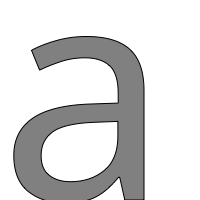

In [13]:
path_orig = get_outline(font, "a")
startdraw(200,200)

paths = []
for i in path_orig:
    if i[0] == 'moveTo':
        path = draw.BezierPath()
        path.moveTo((i[1][0]))
    if i[0] == 'lineTo':
        path.lineTo((i[1][0]))
    if i[0] == 'qCurveTo':
        path.qCurveTo(*(i[1]))
    if i[0] == 'closePath':
        path.closePath()
        paths.append(path)

finalpath = paths[0].difference(paths[1])
finalpath.scale(0.3) #let's scale it down!
draw.fill(0.5)
draw.stroke(0)
draw.drawPath(finalpath)
show()

Ta-da! We made just one single letter, no big deal, you might say. Let's start manipulating all the points to give it a distorted filter:

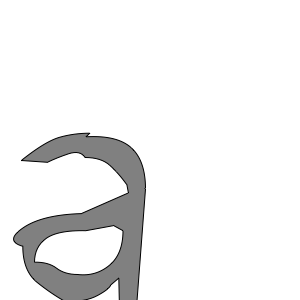

In [14]:
import random
path_orig = get_outline(font, "a")
startdraw(300,300)
paths = []
for i in path_orig:
    disturbance = random.randint(-35, 35)
    if i[0] == 'moveTo':
        x = i[1][0][0] + disturbance
        y = i[1][0][1] + disturbance
        path = draw.BezierPath()
        path.moveTo((x,y))
    if i[0] == 'lineTo':
        x = i[1][0][0] + disturbance
        y = i[1][0][1]+ disturbance
        path.lineTo((x,y))
    if i[0] == 'qCurveTo':
        temp = []
        for cord in i[1]:
            x = cord[0] + disturbance
            y = cord[1] + disturbance
            temp.append((x,y))
        path.qCurveTo(*temp)
    if i[0] == 'closePath':
        path.closePath()
        paths.append(path)
finalpath = paths[0].difference(paths[1])
finalpath.scale(0.3) #let's scale it down!
draw.fill(0.5)
draw.stroke(0)
draw.drawPath(finalpath)
show()

## Parting words ##
See, lots of fun things! :-) That's it from me (at least for now.)

Check out the wiki Page on Github for fontTools if you would like to dig deeper:
[Wiki Page on Github for FontTools](https://github.com/fonttools/fonttools/wiki) 

Wish you the best of luck on your font-navigating journey!